In [3]:
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Function to read the CSV and return the dataframe
def read_csv_to_dataframe(file_path):
    # Read the CSV
    df = pd.read_csv(file_path)
    
    # Ensure the 'Date' column is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)
    
    # Ensure that the 'Open', 'High', 'Low', 'Close' columns are numeric
    df = df[['Open', 'High', 'Low', 'Close']].apply(pd.to_numeric)
    
    return df


def save_plot_figure(fig, filename):
    # Salvar a figura no arquivo especificado
    fig.savefig(filename, bbox_inches='tight')
    
    # Fechar a figura para liberar memória
    plt.close(fig)
    
    return filename

In [4]:
df1 = read_csv_to_dataframe('XAUUSD_D1.csv')
df2 = read_csv_to_dataframe('XAUUSD_H1.csv')
dfm15 = read_csv_to_dataframe('XAUUSD_M15.csv')

In [22]:
df1_aux = df1.loc['2023-10-01':'2024-08-15']
df2_aux = df2.loc['2024-01-01 01:00:00':'2024-08-15 10:00:00']

In [23]:
df1_aux

,Open,High,Low,Close
Date,,,,
2023-10-01,1847.268,1848.645,1845.595,1848.285
2023-10-02,1848.295,1848.835,1820.405,1824.845
2023-10-03,1824.818,1833.205,1815.245,1823.255
2023-10-04,1823.225,1830.455,1816.475,1822.425
2023-10-05,1822.445,1829.105,1812.924,1821.138
...,...,...,...,...
2024-08-11,2430.298,2433.305,2426.835,2427.765
2024-08-12,2427.835,2475.855,2423.695,2475.425
2024-08-13,2475.445,2476.845,2458.365,2463.975


In [14]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import os
import gc  # For garbage collection
from datetime import timedelta

# Function to generate and save charts based on the actual data in the CSV for the year 2024
def generate_charts_from_csv(df1d, df1h, output_dir, num_candles_1d=60, num_candles_1h=80, short_window=10, long_window=40, level_window=20):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Filter the hourly and daily data to only include data from the year 2024
    df1d = df1d[df1d.index.year >= 2023]
    df1h = df1h[df1h.index.year == 2024]

    # Sort the hourly data by date to ensure we iterate in the correct order
    df1h = df1h.sort_index()
    df1d = df1d.sort_index()

    # Make sure we have at least 80 hourly candles before generating charts
    if len(df1h) < num_candles_1h or len(df1d) < num_candles_1d:
        print("Not enough data to start generating charts.")
        return

    # Iterate over each timestamp in the hourly data, starting from index 80
    for idx, current_time in enumerate(df1h.index[num_candles_1h:], start=num_candles_1h):
        # Get the corresponding daily date, adjusted for weekends
        daily_time = current_time - timedelta(days=1)

        # If the current_time is a Monday, adjust to get the last Friday
        if daily_time.weekday() == 6:  # Sunday
            daily_time = current_time - timedelta(days=2)  # Go back to Friday
        elif daily_time.weekday() == 5:  # Saturday
            daily_time = current_time - timedelta(days=1)  # Go back to Friday

        # Now, ensure df1d_filtered ends on the day before current_time (adjusted for weekends)
        end_date_1d = daily_time
        start_date_1d = end_date_1d - timedelta(days=num_candles_1d)

        # Filter the daily data for the last 50 days leading up to the correct daily_time
        df1d_filtered = df1d.loc[start_date_1d:end_date_1d]

        # Skip if there's not enough daily data or it's empty
        if df1d_filtered.empty:
            continue

        # Filter the hourly data for the current time (80 candles in total)
        df1h_filtered = df1h.iloc[idx - num_candles_1h:idx]

        print(df1d_filtered.index[-1], df1h_filtered.index[-1])
        
        # Generate the combined candlestick chart with SMA and support/resistance levels
        fig, (ax1, ax2) = plot_combined_candlestick_with_sma_and_levels(
            df1d_filtered, df1h_filtered,
            num_candles_1d=num_candles_1d,
            num_candles_1h=num_candles_1h,
            title1=f'Candlestick with SMA and Levels (1D) - {end_date_1d.date()}',
            title2=f'Candlestick with SMA and Levels (1H) - {current_time.strftime("%Y-%m-%d %H:%M")}',
            short_window=short_window, long_window=long_window, level_window=level_window
        )

        # Create a filename for saving the image
        filename = os.path.join(output_dir, f'chart_{end_date_1d.strftime("%Y-%m-%d")}_{current_time.strftime("%H-%M")}.jpg')

        # Save the figure as an image
        save_plot_figure(fig, filename)

        # Clear axes to release memory
        ax1.clear()
        ax2.clear()

        # Close the figure to free up memory
        plt.close(fig)
        plt.close('all')

        # Trigger garbage collection
        del fig, ax1, ax2, df1d_filtered, df1h_filtered  # Explicitly delete variables
        gc.collect()  # Force garbage collection

# Example usage
# Assuming df1d (daily data) and df1h (hourly data) are already loaded using read_csv_to_dataframe()
# generate_charts_from_csv(df1d, df1h, 'charts_2024', num_candles_1d=50, num_candles_1h=80)


In [ ]:
generate_charts_from_csv(df1, df2, 'charts_2024-5', num_candles_1d=60, num_candles_1h=80)

2024-01-04 00:00:00 2024-01-05 09:00:00
2024-01-04 00:00:00 2024-01-05 10:00:00
2024-01-04 00:00:00 2024-01-05 11:00:00
2024-01-04 00:00:00 2024-01-05 12:00:00
2024-01-04 00:00:00 2024-01-05 13:00:00
2024-01-04 00:00:00 2024-01-05 14:00:00
2024-01-04 00:00:00 2024-01-05 15:00:00
2024-01-04 00:00:00 2024-01-05 16:00:00
2024-01-04 00:00:00 2024-01-05 17:00:00
2024-01-04 00:00:00 2024-01-05 18:00:00
2024-01-04 00:00:00 2024-01-05 19:00:00
2024-01-04 00:00:00 2024-01-05 20:00:00
2024-01-05 00:00:00 2024-01-05 21:00:00
2024-01-05 00:00:00 2024-01-07 23:00:00
2024-01-05 00:00:00 2024-01-08 00:00:00
2024-01-05 00:00:00 2024-01-08 01:00:00
2024-01-05 00:00:00 2024-01-08 02:00:00
2024-01-05 00:00:00 2024-01-08 03:00:00
2024-01-05 00:00:00 2024-01-08 04:00:00
2024-01-05 00:00:00 2024-01-08 05:00:00
2024-01-05 00:00:00 2024-01-08 06:00:00
2024-01-05 00:00:00 2024-01-08 07:00:00
2024-01-05 00:00:00 2024-01-08 08:00:00
2024-01-05 00:00:00 2024-01-08 09:00:00
2024-01-05 00:00:00 2024-01-08 10:00:00


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fbb0fe01750>
Traceback (most recent call last):
  File "/home/jonatassilva/miniconda3/envs/trade/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


2024-06-17 00:00:00 2024-06-18 07:00:00


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fbb0fee3ac0>
Traceback (most recent call last):
  File "/home/jonatassilva/miniconda3/envs/trade/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


2024-06-17 00:00:00 2024-06-18 08:00:00


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fbb0fe8fbe0>
Traceback (most recent call last):
  File "/home/jonatassilva/miniconda3/envs/trade/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


2024-06-17 00:00:00 2024-06-18 09:00:00
2024-06-17 00:00:00 2024-06-18 10:00:00
2024-06-17 00:00:00 2024-06-18 11:00:00


Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fbb0fdb3be0>
Traceback (most recent call last):
  File "/home/jonatassilva/miniconda3/envs/trade/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


2024-06-17 00:00:00 2024-06-18 12:00:00


In [46]:
df1.index[-1]

Timestamp('2024-08-15 00:00:00')

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta

# Function to create a candlestick chart with Bollinger Bands, ADX, and RSI
def plot_candlestick_with_indicators(df, bollinger_window=20, adx_window=14, rsi_window=14):
    # Calculate Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=bollinger_window).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=bollinger_window).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=bollinger_window).std()

    # Calculate ADX
    df['ADX'] = ta.adx(df['High'], df['Low'], df['Close'], length=adx_window)['ADX_14']

    # Calculate RSI
    df['RSI'] = ta.rsi(df['Close'], length=rsi_window)

    # Set up the chart layout with 3 rows
    fig, (ax_candle, ax_adx, ax_rsi) = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1, 1]})

    # Plot the candlestick chart with Bollinger Bands on the first axis
    mpf.plot(df, type='candle', ax=ax_candle, style='charles', 
             ylabel='Price',
             addplot=[
                 mpf.make_addplot(df['BB_Upper'], ax=ax_candle, color='blue', linestyle='dashed'),
                 mpf.make_addplot(df['BB_Middle'], ax=ax_candle, color='orange'),
                 mpf.make_addplot(df['BB_Lower'], ax=ax_candle, color='blue', linestyle='dashed')
             ],
             show_nontrading=True  # Ensure non-trading periods do not conflict with plot
            )

    # Set title manually
    ax_candle.set_title('Candlestick with Bollinger Bands')

    # Plot ADX on the second axis
    ax_adx.plot(df.index, df['ADX'], label='ADX', color='green')
    ax_adx.set_title('ADX (Average Directional Index)')
    ax_adx.set_ylabel('ADX Value')
    ax_adx.legend()

    # Plot RSI on the third axis
    ax_rsi.plot(df.index, df['RSI'], label='RSI', color='purple')
    ax_rsi.axhline(30, color='red', linestyle='--')  # Overbought line
    ax_rsi.axhline(70, color='red', linestyle='--')  # Oversold line
    ax_rsi.set_title('RSI (Relative Strength Index)')
    ax_rsi.set_ylabel('RSI Value')
    ax_rsi.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Assuming df contains 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
# df = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# plot_candlestick_with_indicators(df)


/home/jonatassilva/miniconda3/envs/trade/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


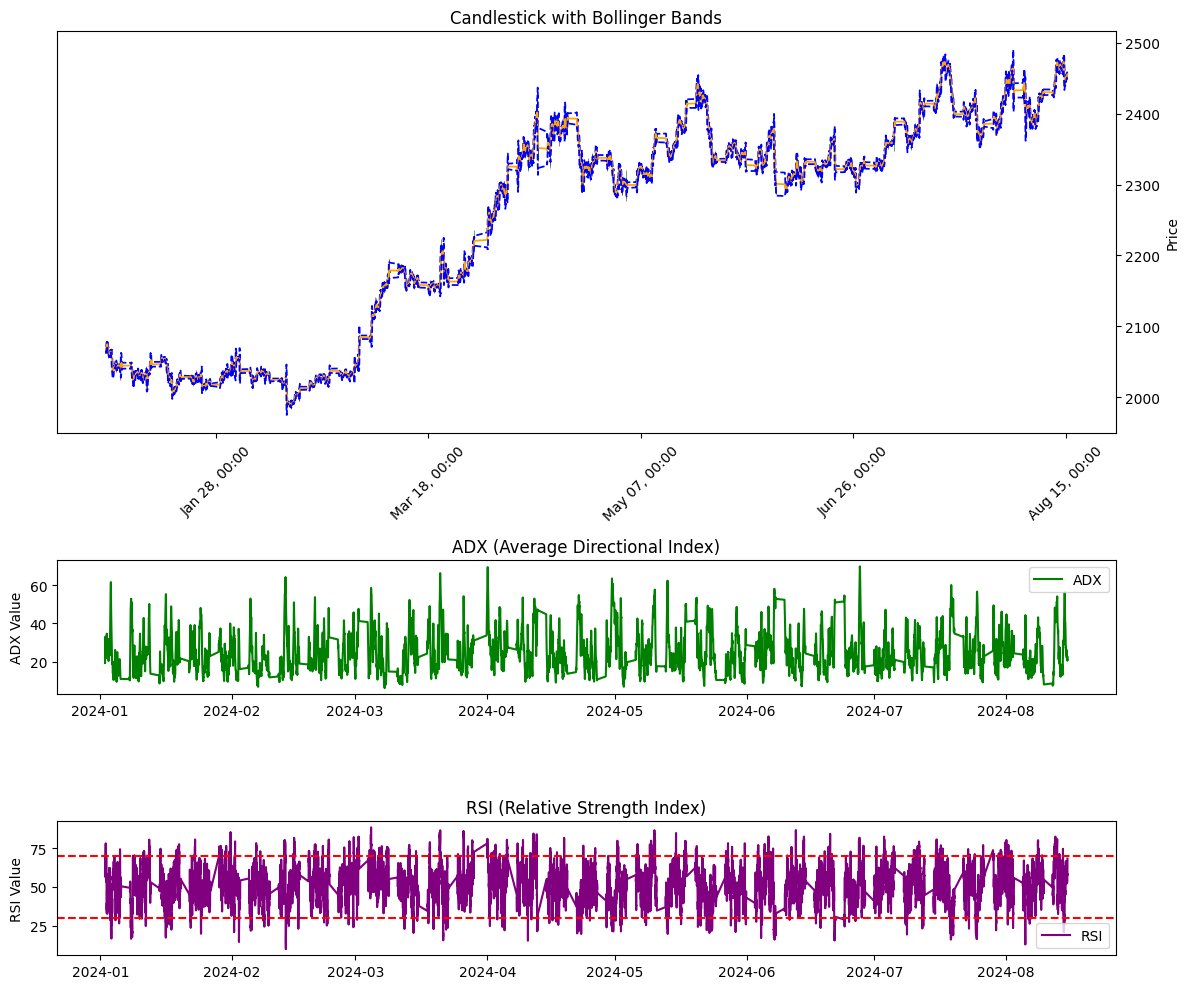

In [9]:
# Example usage
# Assuming df contains 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
# df = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
dfm15 = dfm15.loc['2024-01-01 01:00:00':'2024-08-15 10:00:00']
plot_candlestick_with_indicators(dfm15)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_ta as ta
import os

# Function to create and save a candlestick chart with Bollinger Bands, ADX, and RSI
def plot_and_save_candlestick_with_indicators(df, output_dir, file_name, bollinger_window=40, adx_window=30, rsi_window=30):
    # Calculate Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=bollinger_window).mean()
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=bollinger_window).std()
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=bollinger_window).std()

    # Calculate ADX
    df['ADX'] = ta.adx(df['High'], df['Low'], df['Close'], length=adx_window)['ADX_30']

    # Calculate RSI
    df['RSI'] = ta.rsi(df['Close'], length=rsi_window)

    # Set up the chart layout with 3 rows
    fig, (ax_candle, ax_adx, ax_rsi) = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1, 1]})

    # Plot the candlestick chart with Bollinger Bands on the first axis
    mpf.plot(df, type='candle', ax=ax_candle, style='charles', 
             ylabel='Price',
             addplot=[
                 mpf.make_addplot(df['BB_Upper'], ax=ax_candle, color='blue', linestyle='dashed'),
                 mpf.make_addplot(df['BB_Middle'], ax=ax_candle, color='orange'),
                 mpf.make_addplot(df['BB_Lower'], ax=ax_candle, color='blue', linestyle='dashed')
             ],
             show_nontrading=True
            )

    # Set title manually
    ax_candle.set_title('Candlestick with Bollinger Bands')

    # Highlight the last Close value
    last_close = df['Close'].iloc[-1]
    last_close_time = df.index[-1]
    ax_candle.annotate(f'Last Close: {last_close:.2f}', 
                       xy=(last_close_time, last_close), 
                       xytext=(last_close_time, last_close),
                       bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="yellow"))

    # Plot ADX on the second axis
    ax_adx.plot(df.index, df['ADX'], label='ADX', color='green')
    ax_adx.set_title('ADX (Average Directional Index)')
    ax_adx.set_ylabel('ADX Value')
    ax_adx.legend()

    # Highlight the last ADX value
    last_adx = df['ADX'].iloc[-1]
    ax_adx.annotate(f'Last ADX: {last_adx:.2f}', 
                    xy=(last_close_time, last_adx), 
                    xytext=(last_close_time, last_adx),
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="yellow"))

    # Plot RSI on the third axis
    ax_rsi.plot(df.index, df['RSI'], label='RSI', color='purple')
    ax_rsi.axhline(30, color='red', linestyle='--')  # Overbought line
    ax_rsi.axhline(70, color='red', linestyle='--')  # Oversold line
    ax_rsi.set_title('RSI (Relative Strength Index)')
    ax_rsi.set_ylabel('RSI Value')
    ax_rsi.legend()

    # Highlight the last RSI value
    last_rsi = df['RSI'].iloc[-1]
    ax_rsi.annotate(f'Last RSI: {last_rsi:.2f}', 
                    xy=(last_close_time, last_rsi), 
                    xytext=(last_close_time, last_rsi),
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="yellow"))

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure as an image
    output_path = os.path.join(output_dir, file_name)
    plt.savefig(output_path)

    # Close the plot to free up memory
    plt.close(fig)

# Main function to loop through the data and generate charts for August
def generate_charts_for_august(df, output_dir, num_candles=100):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Filter data for August
    df_august = df[df.index.month == 8]

    # Iterate through the data in windows of 100 candles
    for i in range(len(df_august) - num_candles + 1):
        df_window = df_august.iloc[i:i + num_candles]
        print(df_window.index[-1])
        
        # Generate file name for the chart
        start_date = df_window.index[0].strftime('%Y-%m-%d_%H-%M')
        end_date = df_window.index[-1].strftime('%Y-%m-%d_%H-%M')
        file_name = f'chart_{start_date}_to_{end_date}.jpg'

        # Plot and save the candlestick chart with indicators
        plot_and_save_candlestick_with_indicators(df_window, output_dir, file_name)

# Example usage
# Assuming df contains 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
# df = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# generate_charts_for_august(df, 'charts_august', num_candles=100)


In [22]:
# Example usage
# Assuming df contains 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'
# df = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
generate_charts_for_august(dfm15, 'charts_august', num_candles=100)

2024-08-02 01:45:00
2024-08-02 02:00:00
2024-08-02 02:15:00
2024-08-02 02:30:00
2024-08-02 02:45:00
2024-08-02 03:00:00
2024-08-02 03:15:00
2024-08-02 03:30:00
2024-08-02 03:45:00
2024-08-02 04:00:00
2024-08-02 04:15:00
2024-08-02 04:30:00
2024-08-02 04:45:00
2024-08-02 05:00:00
2024-08-02 05:15:00
2024-08-02 05:30:00
2024-08-02 05:45:00
2024-08-02 06:00:00
2024-08-02 06:15:00
2024-08-02 06:30:00
2024-08-02 06:45:00
2024-08-02 07:00:00
2024-08-02 07:15:00
2024-08-02 07:30:00
2024-08-02 07:45:00
2024-08-02 08:00:00
2024-08-02 08:15:00
2024-08-02 08:30:00
2024-08-02 08:45:00
2024-08-02 09:00:00
2024-08-02 09:15:00
2024-08-02 09:30:00
2024-08-02 09:45:00
2024-08-02 10:00:00
2024-08-02 10:15:00
2024-08-02 10:30:00
2024-08-02 10:45:00
2024-08-02 11:00:00
2024-08-02 11:15:00
2024-08-02 11:30:00
2024-08-02 11:45:00
2024-08-02 12:00:00
2024-08-02 12:15:00
2024-08-02 12:30:00
2024-08-02 12:45:00
2024-08-02 13:00:00
2024-08-02 13:15:00
2024-08-02 13:30:00
2024-08-02 13:45:00
2024-08-02 14:00:00
